# CIFAR10 & PyTorch

## 00. Load & Visualize CIFAR10 Dataset

In [1]:
import os
import torch

DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), '..\\..\\data\\CIFAR10'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

In [2]:
import torchvision

train_data = torchvision.datasets.CIFAR10(
    download=True,
    root=DATA_PATH,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010)),
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
    ]),
    train=True,
)

test_data = torchvision.datasets.CIFAR10(
    download=True,
    root=DATA_PATH,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                         (0.2023, 0.1994, 0.2010)),
    ]),
    train=False,
)

train_data.data.shape, len(train_data.targets)

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), 50000)

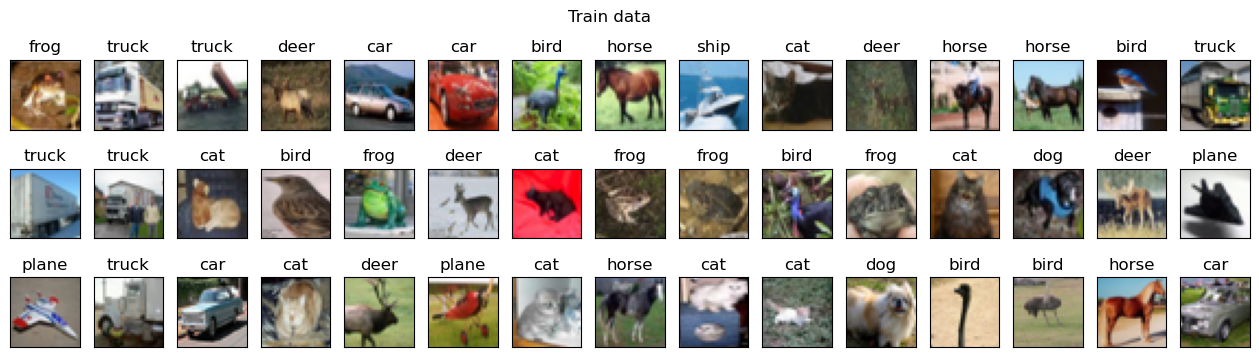

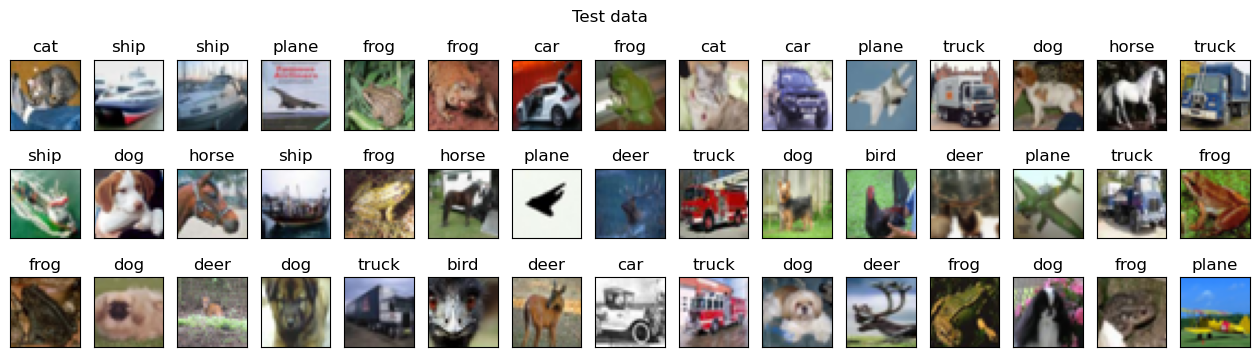

In [3]:
import matplotlib.pyplot as plt
classes = list(('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))

def show_images(images: list, labels: list, rows, cols, title=None):
    fig, ax = plt.subplots(rows, cols, figsize=(16,4))
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    for i, ax in enumerate(fig.axes):
        ax.imshow(images[i])
        ax.set_title(classes[labels[i]])

show_images(train_data.data, train_data.targets, 3, 15, title="Train data")
show_images(test_data.data, test_data.targets, 3, 15, title="Test data")

## 01. Data Loader & Model

In [4]:
from torch.utils.data import DataLoader

batch_size = 128

train_data_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)

In [5]:
class BasicBlock(torch.nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

        if stride != 1 or inplanes != planes:
            self.shortcut = torch.nn.Sequential(
                torch.nn.Conv2d(inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes)
            )
        else:
            self.shortcut = torch.nn.Sequential()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.inplanes = 64

        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, padding=3, bias=False) # stride=2 -> stride=1
        self.bn1 = torch.nn.BatchNorm2d(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        # self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, num_blocks=2)
        self.layer2 = self._make_layer(128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(512, num_blocks=2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride=1):

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride=stride))
        self.inplanes = planes
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(self.inplanes, planes))

        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [6]:
model = ResNet18(num_classes=10)
model = model.to(device)
model

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

## 02. Training Loop & Evaluation

In [7]:
import time

logs = {"loss": [], "accuracy": []}
epochs = 75
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
sceduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
loss_function = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    total = correct = 0
    train_loss = 0
    start_time = time.time()
    for i, (inputs, targets) in enumerate(train_data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs : torch.Tensor = model(inputs)

        loss: torch.Tensor = loss_function(outputs, targets)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sceduler.step()

        correct += outputs.argmax(dim=1).eq(targets).sum().item()
        total += targets.size(dim=0)
    end_time = time.time()

    logs["loss"].append(train_loss / len(train_data_loader))
    logs["accuracy"].append(correct / total)
    print(f"epoch {epoch + 1}/{epochs}: loss = {logs['loss'][-1]:.3f}, accuracy = {logs['accuracy'][-1]:.3f}, {end_time - start_time:.3f} s/it")

epoch 1/75: loss = 1.510, accuracy = 0.446, 48.948 s/it
epoch 2/75: loss = 1.145, accuracy = 0.589, 52.348 s/it
epoch 3/75: loss = 0.909, accuracy = 0.676, 52.012 s/it
epoch 4/75: loss = 0.791, accuracy = 0.724, 40.739 s/it
epoch 5/75: loss = 0.684, accuracy = 0.761, 44.425 s/it
epoch 6/75: loss = 0.624, accuracy = 0.783, 48.477 s/it
epoch 7/75: loss = 0.571, accuracy = 0.800, 48.791 s/it
epoch 8/75: loss = 0.514, accuracy = 0.820, 48.455 s/it
epoch 9/75: loss = 0.503, accuracy = 0.824, 48.356 s/it
epoch 10/75: loss = 0.458, accuracy = 0.841, 47.311 s/it
epoch 11/75: loss = 0.421, accuracy = 0.854, 47.261 s/it
epoch 12/75: loss = 0.407, accuracy = 0.860, 47.211 s/it
epoch 13/75: loss = 0.380, accuracy = 0.866, 47.410 s/it
epoch 14/75: loss = 0.369, accuracy = 0.872, 47.488 s/it
epoch 15/75: loss = 0.347, accuracy = 0.880, 47.457 s/it
epoch 16/75: loss = 0.328, accuracy = 0.886, 47.382 s/it
epoch 17/75: loss = 0.321, accuracy = 0.889, 47.372 s/it
epoch 18/75: loss = 0.294, accuracy = 0.

In [8]:
def get_accuracy(model, data_loader):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = torch.argmax(outputs, dim=1)
            
            n += labels.size(dim=0)
            tp += (predicted == labels).sum()
    return (tp / n).item()

test_accuracy = get_accuracy(model, test_data_loader)
f"test accuracy = {test_accuracy:.3f}"

'test accuracy = 0.914'

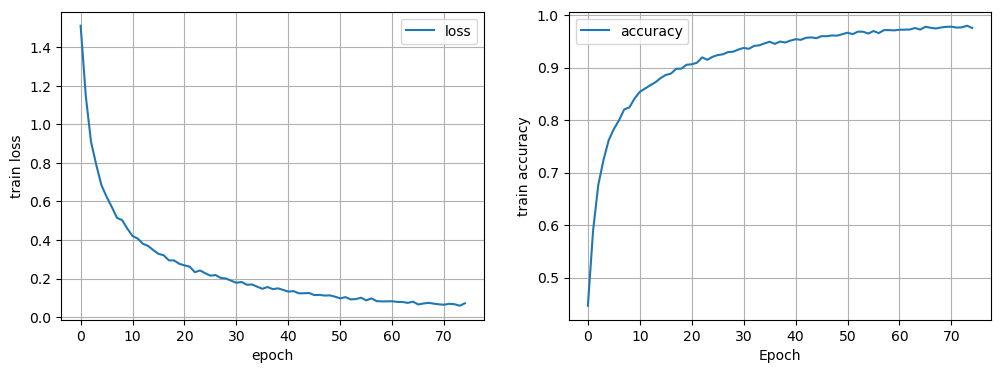

In [9]:
import matplotlib.pyplot as plt

def logs_plot(logs):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(logs["loss"])
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("train loss")
    ax[0].legend(["loss"])
    ax[0].grid()

    ax[1].plot(logs["accuracy"])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("train accuracy")
    ax[1].legend(["accuracy"])
    ax[1].grid()

    plt.show()

logs_plot(logs)

In [10]:
torch.save(model, "../../checkpoint/ResNet18.pt")